# Goals
The goals of this analysis are to map the relationship between combinatorial ligand pairs. I will focus mainly on mapping relationships based on correlation due to its scale-invariant nature.

# Import Data

In [ ]:
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import re
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [2]:
# import anndata
dataNorm = ad.read_h5ad('/data/rudensky/EYW/SIG07/scanpy_outs/SIG07_doublets_CR_RNA_zscore.h5ad')

# Helper Functions
Here I'm just adding a few helper functions to make plotting the heatmaps easier

In [2]:
def mean_aggr(adata, aggregate_columns=['ligand_call_oBC_CR']):
    # Create a DataFrame from the AnnData object
    df = pd.DataFrame(adata.X.toarray(), index=adata.obs.index, columns=adata.var_names)
    df[aggregate_columns] = adata.obs[aggregate_columns]
    
    # Calculate mean expression grouped by `ligand_call_oBC_CR`
    mean_aggregated = df.groupby(aggregate_columns,observed=True).mean()
    
    return mean_aggregated

In [3]:
def mean_aggr_adata(adata, aggregate_columns=['ligand_call_oBC_CR']):
    """
    Aggregates an AnnData object by calculating mean expressions for groups defined by `aggregate_columns`.

    Parameters:
    -----------
    adata : AnnData
        Input AnnData object.
    aggregate_columns : list
        List of columns in `adata.obs` used to group and aggregate the data.

    Returns:
    --------
    AnnData
        A new AnnData object with aggregated (mean) expressions and updated `obs` and `var`.
    """
    # Create a DataFrame from the AnnData object
    df = pd.DataFrame(adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X,
                      index=adata.obs.index, 
                      columns=adata.var_names)
    
    # Add aggregate columns to the DataFrame
    for col in aggregate_columns:
        df[col] = adata.obs[col]
    
    # Group by the specified columns and compute mean expression
    mean_aggregated = df.groupby(aggregate_columns, observed=True).mean()
    
    # Extract the index of the grouped DataFrame (group identifiers)
    new_obs = mean_aggregated.index.to_frame(index=False)  # Convert MultiIndex to DataFrame
    
    # Convert the mean values back to a matrix
    new_X = mean_aggregated.values
    
    # Create a new AnnData object
    aggregated_adata = ad.AnnData(
        X=new_X,
        obs=new_obs,
        var=adata.var.copy()  # Retain the original gene information
    )
    
    return aggregated_adata

In [4]:
def generate_corr(adata, aggregate_columns=['ligand_call_oBC_CR']):
   # Create a DataFrame from the AnnData object
    df = pd.DataFrame(adata.X.toarray(), index=adata.obs.index, columns=adata.var_names)
    df[aggregate_columns] = adata.obs[aggregate_columns]
    
    # Calculate mean expression grouped by `ligand_call_oBC_CR`
    mean_aggregated = df.groupby(aggregate_columns,observed=True).mean()
    # Calculate the correlation matrix
    correlation_matrix = mean_aggregated.T.corr()
    
    return correlation_matrix

In [5]:
def generate_ligand_anno(adata):
    # Generate annotation DataFrame for the heatmap
    anno = adata.obs[['ligand_call_oBC_CR']].copy()
    anno[['first_ligand', 'second_ligand']] = anno['ligand_call_oBC_CR'].str.split('_', expand=True)
    anno = anno[['ligand_call_oBC_CR', 'first_ligand', 'second_ligand']].drop_duplicates()
    anno.set_index('ligand_call_oBC_CR', inplace=True)

    # Combine unique ligands from both columns
    unique_ligands = pd.concat([anno['first_ligand'], anno['second_ligand']]).unique()
    # Generate a color palette for the unique ligands
    ligand_palette = sns.color_palette("tab10", n_colors=len(unique_ligands))
    # Create a mapping of ligands to colors
    ligand_color_map = {ligand: ligand_palette[i] for i, ligand in enumerate(unique_ligands)}

    # Map the colors to `first_ligand` and `second_ligand`
    first_ligand_colors = anno['first_ligand'].map(ligand_color_map)
    second_ligand_colors = anno['second_ligand'].map(ligand_color_map)

    # Create a DataFrame for the colors
    color_annotations = pd.DataFrame({
          'first_ligand': first_ligand_colors,
          'second_ligand': second_ligand_colors
    }, index=anno.index)
    # reindex to match correlation matrix
    color_annotations = color_annotations.reindex(correlation_matrix.index)

    # Add a legend for the ligands
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color=ligand_color_map[ligand], linestyle='', markersize=10)
        for ligand in unique_ligands
    ]
    
    return color_annotations, unique_ligands, legend_handles

In [6]:
# takes a vector of ligand names as input
def generate_ligand_anno_from_names(ligand_names):
    # Generate annotation DataFrame for the heatmap
    anno = pd.DataFrame(ligand_names)
    anno[['first_ligand', 'second_ligand']] = anno['interaction'].str.split('_', expand=True)
    anno = anno[['interaction', 'first_ligand', 'second_ligand']].drop_duplicates()
    anno.set_index('interaction', inplace=True)

    # Combine unique ligands from both columns
    unique_ligands = pd.concat([anno['first_ligand'], anno['second_ligand']]).unique()
    # Generate a color palette for the unique ligands
    ligand_palette = sns.color_palette("tab10", n_colors=len(unique_ligands))
    # Create a mapping of ligands to colors
    ligand_color_map = {ligand: ligand_palette[i] for i, ligand in enumerate(unique_ligands)}

    # Map the colors to `first_ligand` and `second_ligand`
    first_ligand_colors = anno['first_ligand'].map(ligand_color_map)
    second_ligand_colors = anno['second_ligand'].map(ligand_color_map)

    # Create a DataFrame for the colors
    color_annotations = pd.DataFrame({
            'first_ligand': first_ligand_colors,
            'second_ligand': second_ligand_colors
    }, index=anno.index)
    # reindex to match correlation matrix
    color_annotations = color_annotations.reindex(ligand_names)

    # Add a legend for the ligands
    legend_handles = [
            plt.Line2D([0], [0], marker='o', color=ligand_color_map[ligand], linestyle='', markersize=10)
            for ligand in unique_ligands
    ]
    
    return color_annotations, unique_ligands, legend_handles

In [7]:
import re
# helper function to remove genes based on regex matching from HVG column
def update_highly_variable_genes(adata, regex_pattern, variable_gene_column='highly_variable'):
    """
    Filters and updates the 'highly_variable' column in an AnnData object by removing genes matching a regex pattern.

    Parameters:
    - adata (AnnData): The AnnData object containing the data.
    - regex_pattern (str): The regex pattern to identify genes to be removed from 'highly_variable'.
    - variable_gene_column (str): The column in `adata.var` indicating highly variable genes.

    Returns:
    - adata (AnnData): The modified AnnData object with the updated 'highly_variable' column.
    - matching_genes (list): A list of genes that matched the regex pattern.
    """
    # Ensure the variable_gene_column exists
    if variable_gene_column not in adata.var:
        raise ValueError(f"'{variable_gene_column}' column not found in adata.var")

    # Extract the list of highly variable genes
    highly_variable_genes = adata.var_names[adata.var[variable_gene_column]]

    # Compile the regex pattern
    regex = re.compile(regex_pattern)

    # Find genes matching the regex pattern
    matching_genes = [gene for gene in highly_variable_genes if regex.match(gene)]

    # Update the 'highly_variable' column: set matching genes to False
    adata.var[variable_gene_column] = adata.var_names.isin(highly_variable_genes)
    adata.var.loc[adata.var_names.isin(matching_genes), variable_gene_column] = False

    # Return the updated AnnData object and the list of matching genes
    return adata, matching_genes

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_anno(corr_matrix, anno, legend_handles, unique_ligands, 
                      title='Heatmap', xlabel='Pearson\ncorr', cmap='magma',
                      method='ward', vmax=1, vmin=0, width=12, height=10):
    """
    Plots a customizable heatmap with clustering and annotations.

    Parameters:
        corr_matrix (DataFrame): The data for the heatmap (correlation matrix).
        anno (DataFrame): DataFrame of annotations for rows.
        legend_handles (list): Handles for the legend.
        unique_ligands (list): List of unique ligands for the legend.
        title (str): Title of the heatmap.
        cmap (str): Colormap for the heatmap.
        method (str): Clustering method (e.g., 'ward', 'average').
        vmax (float): Maximum value for the color scale.
    """
    g = sns.clustermap(
        corr_matrix, 
        annot=False, 
        cmap=cmap,
        method=method,
        vmax=vmax, 
        vmin=vmin,
        dendrogram_ratio=(.1, 0),  # Adjusts the width of the dendrogram
        xticklabels=True,  # Ensures all x-axis labels are shown
        yticklabels=True,  # Ensures all y-axis labels are shown
        row_colors=anno,
        cbar_kws={
            'orientation': 'vertical',  # Vertical colorbar
            'shrink': 0.5,  # Shrink the colorbar size
        },
        figsize=(width, height)
    )

    # Adjust the colorbar and tick labels
    g.cax.set_position([1.03, 0.5, .03, .2])  # [x, y, width, height] for the colorbar position
    g.cax.set_xlabel('Pearson\ncorr', fontsize=10)  # Set horizontal label
    g.cax.xaxis.set_label_position('top')  # Position the label below the colorbar

    # Move the row_colors bar to the right
    row_colors_ax = g.ax_row_colors
    row_colors_position = row_colors_ax.get_position()
    row_colors_ax.set_position([0.1, row_colors_position.y0, 0.04, row_colors_position.height])  # [x, y, width, height]

    # Add legend for ligands
    g.ax_heatmap.legend(
        legend_handles,
        unique_ligands,
        title="Ligands",
        bbox_to_anchor=(1.15, 1),
        loc='upper left'
    )

    # Customize labels and title
    g.ax_heatmap.set_xlabel("")
    g.ax_heatmap.set_ylabel("")
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
    g.ax_heatmap.set_title(title, fontsize=20)

    plt.show()

# Transcript Correlation Heatmaps

## UMI Norm HM

In [10]:
# make copy of data 
adata = dataNorm.copy()
adata.X = adata.layers['log1p_norm'].copy()

In [14]:
# filter to remove low genes
sc.pp.filter_genes(adata, min_cells=len(adata)*0.01) # filter for genes in >1% of cells
# find HVGs
sc.pp.highly_variable_genes(adata, n_top_genes=3100-81)
# Remove TCR and IG genes
adata, matching_genes = update_highly_variable_genes(adata, r"^Tra[vj]|^Trb[vdj]|^Igk[vc]|^Igl[vc]|^Ighv")
print(f"Number of highly variable genes remaining: {adata.var['highly_variable'].sum()}")

Number of highly variable genes remaining: 3000


In [15]:
# make correlation matrix and ligand annotations
adata_hv = adata[:, adata.var['highly_variable']]
correlation_matrix = generate_corr(adata_hv)
anno, unique_ligands, legend_handles = generate_ligand_anno(adata_hv)

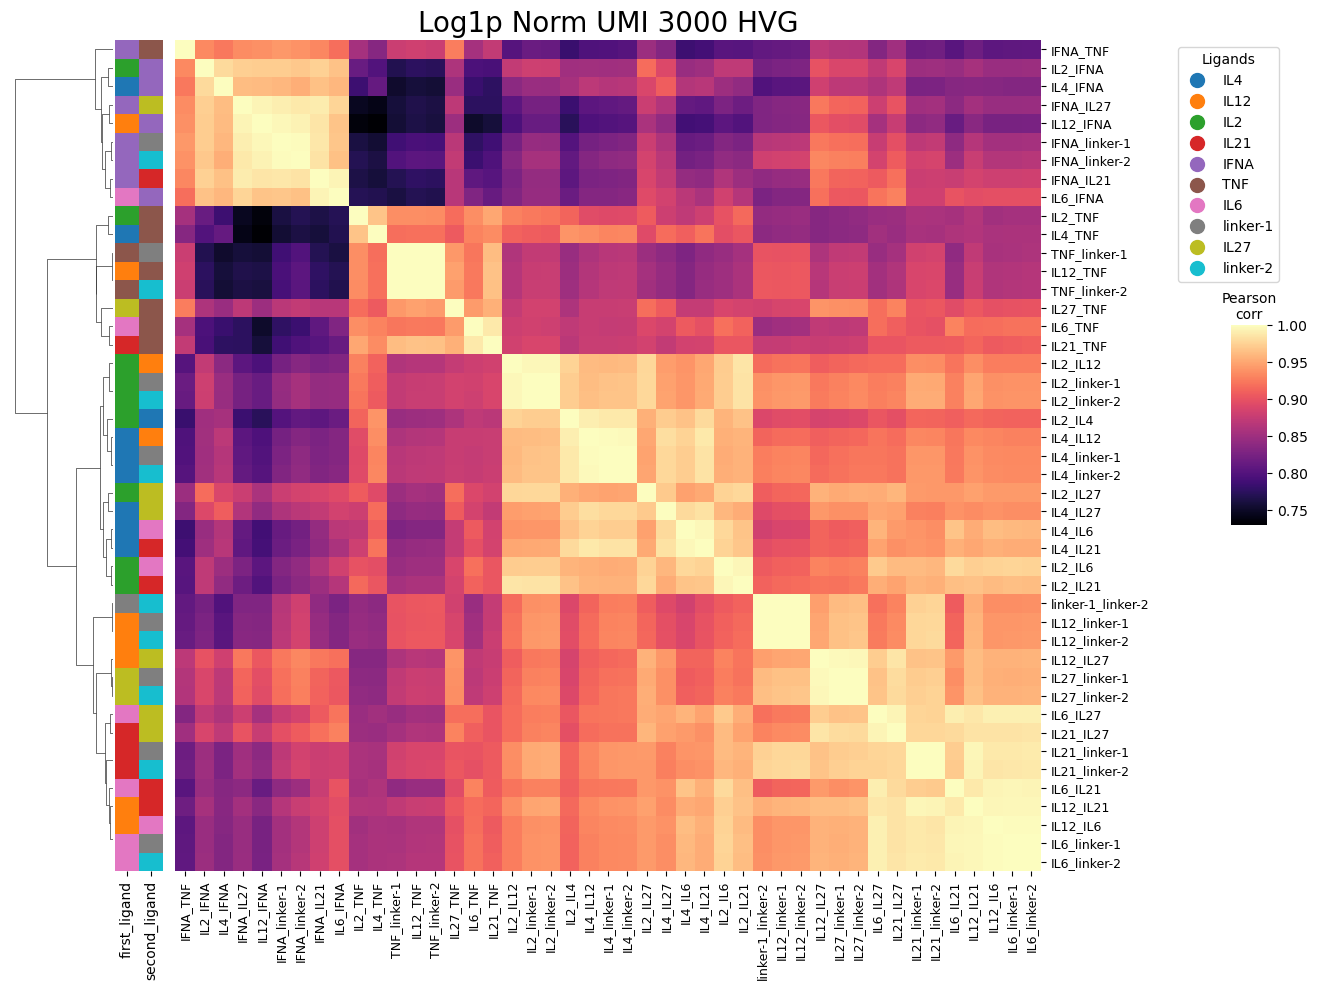

In [20]:
plot_heatmap_anno(
    corr_matrix=correlation_matrix,
    anno=anno,
    legend_handles=legend_handles,
    unique_ligands=unique_ligands,
    title='Log1p Norm UMI 3000 HVG',
    cmap='magma',
    method='ward'
)

## Zscore HM

In [17]:
# process data
adata.X = adata.layers['zscore_group'].copy()

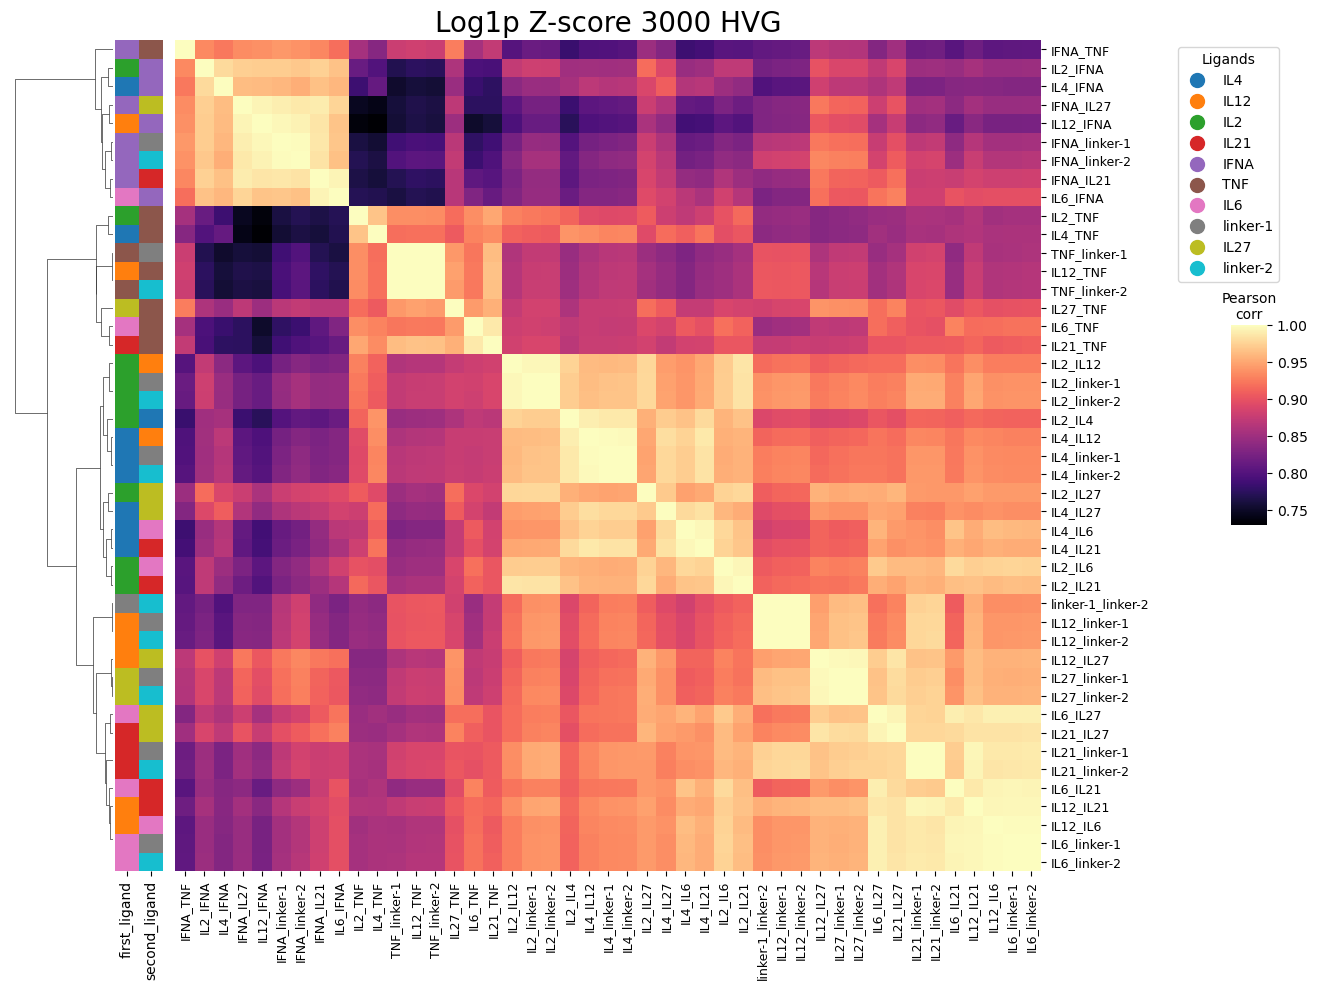

In [18]:
plot_heatmap_anno(
    corr_matrix=correlation_matrix,
    anno=anno,
    legend_handles=legend_handles,
    unique_ligands=unique_ligands,
    title='Log1p Z-score 3000 HVG',
    cmap='magma',
    method='ward'
)

# Interaction Coefficient Correlation HM
Here, I'll look at the correlation between ligands based on the coefficients from the gene-wise GLM model

In [ ]:
# import glm coefficients calculated for top 3000 HVGs
glmCoeffHVG = pd.read_csv("/data/rudensky/EYW/git_projects/SIG07/analysis_outs/glmGamPoi_coefficients_HVG.csv")
# import glm coefficients calculated with full gene list
glmCoeff = pd.read_csv("/data/rudensky/EYW/git_projects/SIG07/analysis_outs/glmGamPoi_coefficients_allGenes.csv")

## HVG genes only

In [ ]:
# make matrix of interaction coefficients
interCoeffHVG_matrix = glmCoeffHVG.pivot(index='interaction',
                                   columns='genes',
                                   values='ligand1:ligand2')
ligand1HVG_matrix = glmCoeffHVG.pivot(index='interaction',
                                   columns='genes',
                                   values='ligand1')
ligand2HVG_matrix = glmCoeffHVG.pivot(index='interaction',
                                   columns='genes',
                                   values='ligand2')

# calculate correlation matrices
interCoeffCorrHVG = interCoeffHVG_matrix.T.corr(method='spearman')
ligand1CorrHVG = ligand1HVG_matrix.T.corr(method='spearman')
ligand2CorrHVG = ligand2HVG_matrix.T.corr(method='spearman')

# create annotations
anno, unique_ligands, legend_handles = generate_ligand_anno_from_names(interCoeffCorrHVG.index)

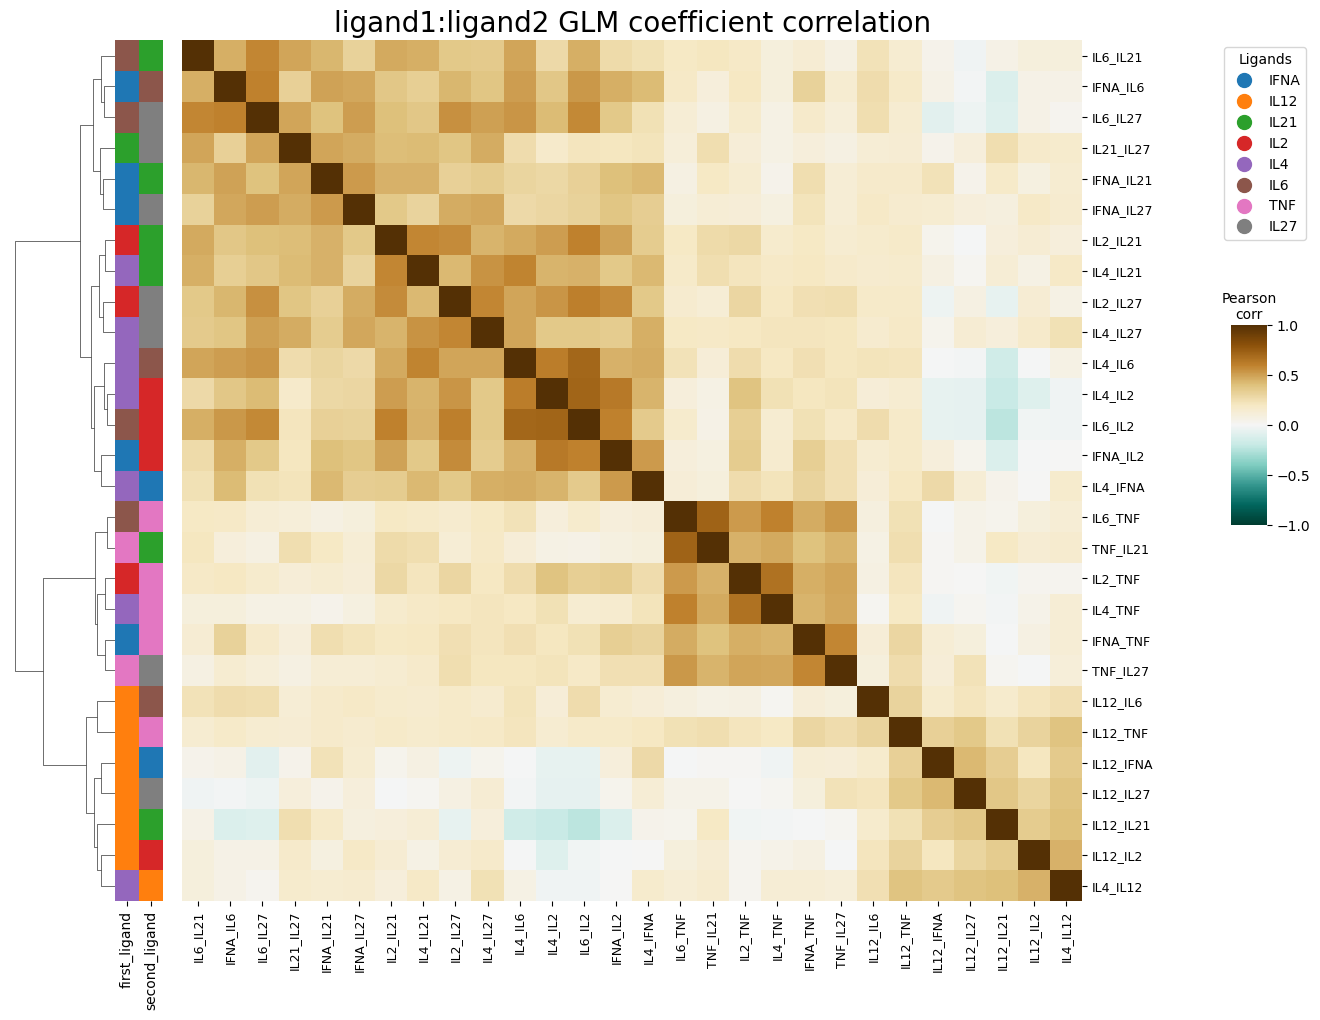

In [32]:
plot_heatmap_anno(
    corr_matrix=interCoeffCorrHVG,
    anno=anno,
    legend_handles=legend_handles,
    unique_ligands=unique_ligands,
    title='ligand1:ligand2 GLM coefficient correlation',
    cmap='BrBG_r',
    method='ward',
    vmax=1,
    vmin=-1
)

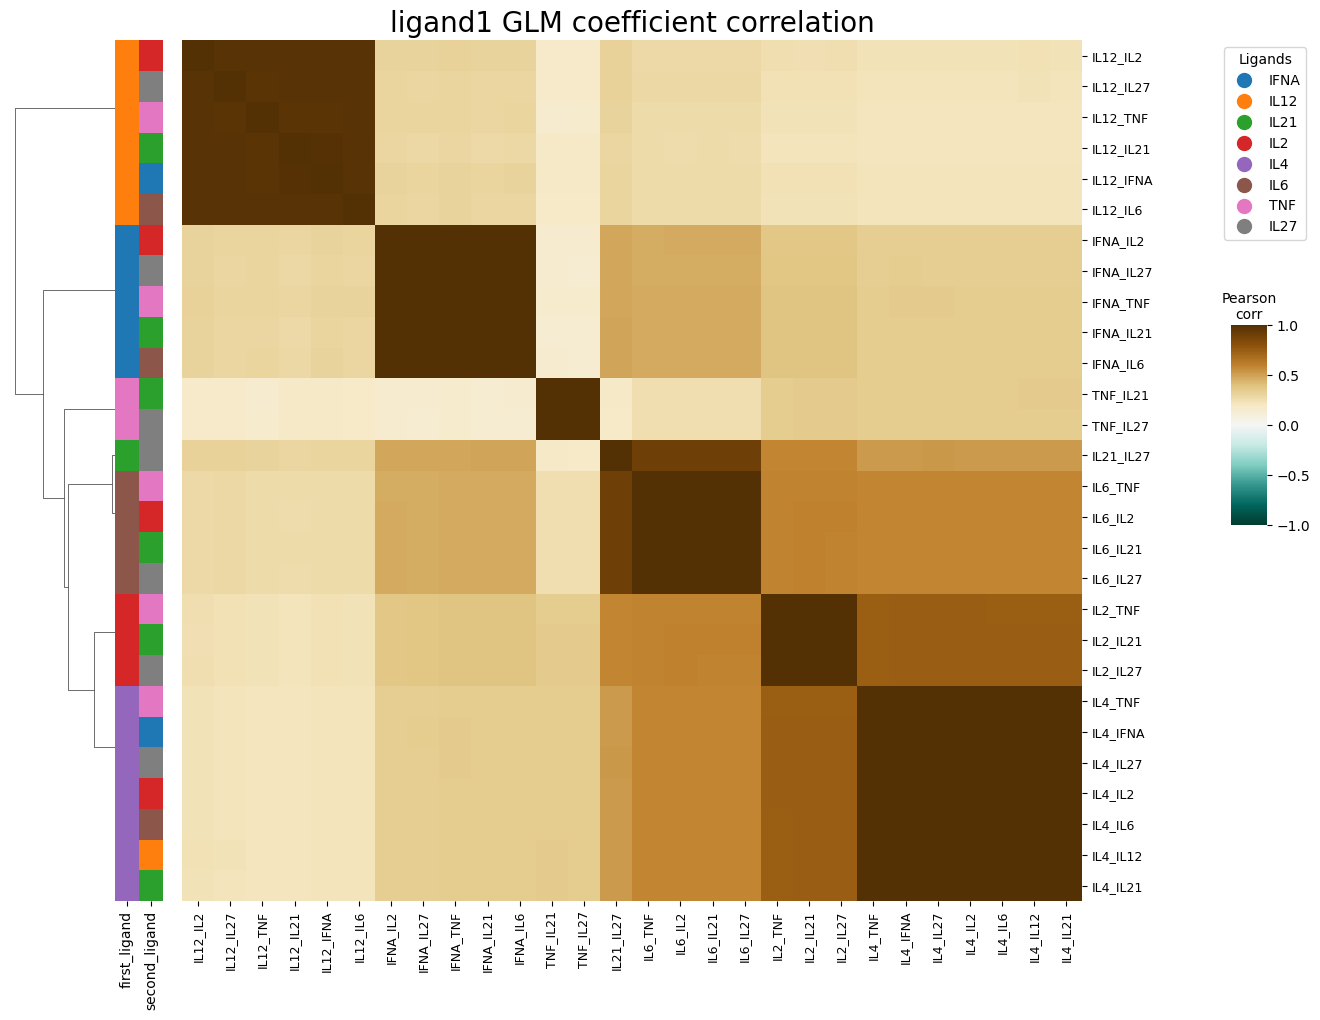

In [33]:
plot_heatmap_anno(
    corr_matrix=ligand1CorrHVG,
    anno=anno,
    legend_handles=legend_handles,
    unique_ligands=unique_ligands,
    title='ligand1 GLM coefficient correlation',
    cmap='BrBG_r',
    method='ward',
    vmax=1,
    vmin=-1
)

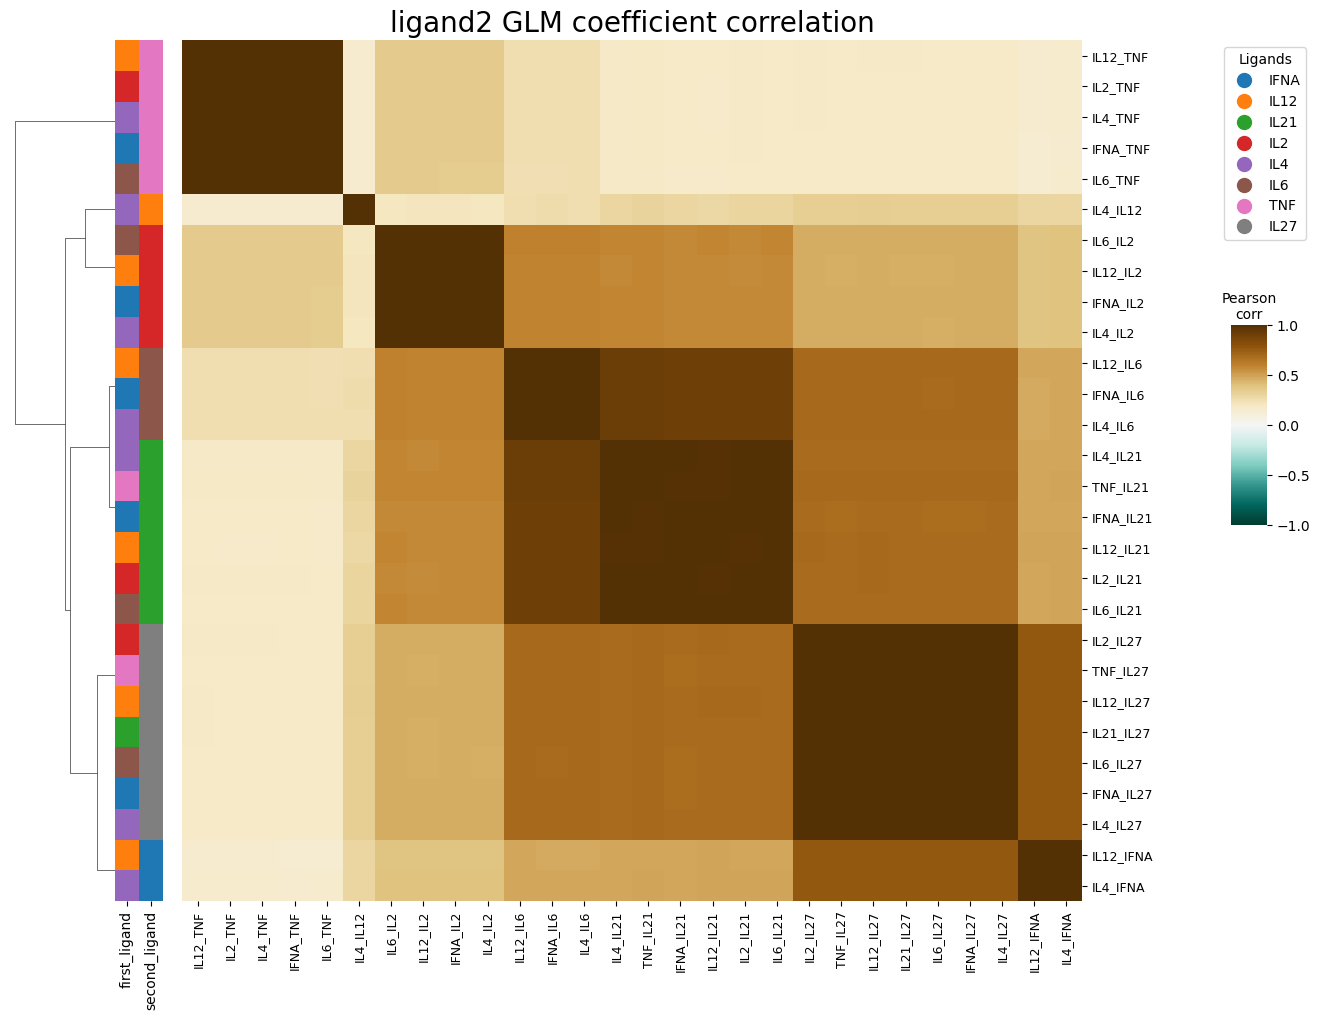

In [34]:
plot_heatmap_anno(
    corr_matrix=ligand2CorrHVG,
    anno=anno,
    legend_handles=legend_handles,
    unique_ligands=unique_ligands,
    title='ligand2 GLM coefficient correlation',
    cmap='BrBG_r',
    method='ward',
    vmax=1,
    vmin=-1
)

# All Genes

In [60]:
# make matrix of interaction coefficients
interCoeff_matrix = glmCoeff.pivot(index='interaction',
                                   columns='genes',
                                   values='ligand1:ligand2')
ligand1_matrix = glmCoeff.pivot(index='interaction',
                                   columns='genes',
                                   values='ligand1')
ligand2_matrix = glmCoeff.pivot(index='interaction',
                                   columns='genes',
                                   values='ligand2')
interCoeffCorr = interCoeff_matrix.T.corr(method='spearman')
ligand1Corr = ligand1_matrix.T.corr(method='spearman')
ligand2Corr = ligand2_matrix.T.corr(method='spearman')

In [61]:
anno, unique_ligands, legend_handles = generate_ligand_anno_from_names(interCoeffCorr.index)

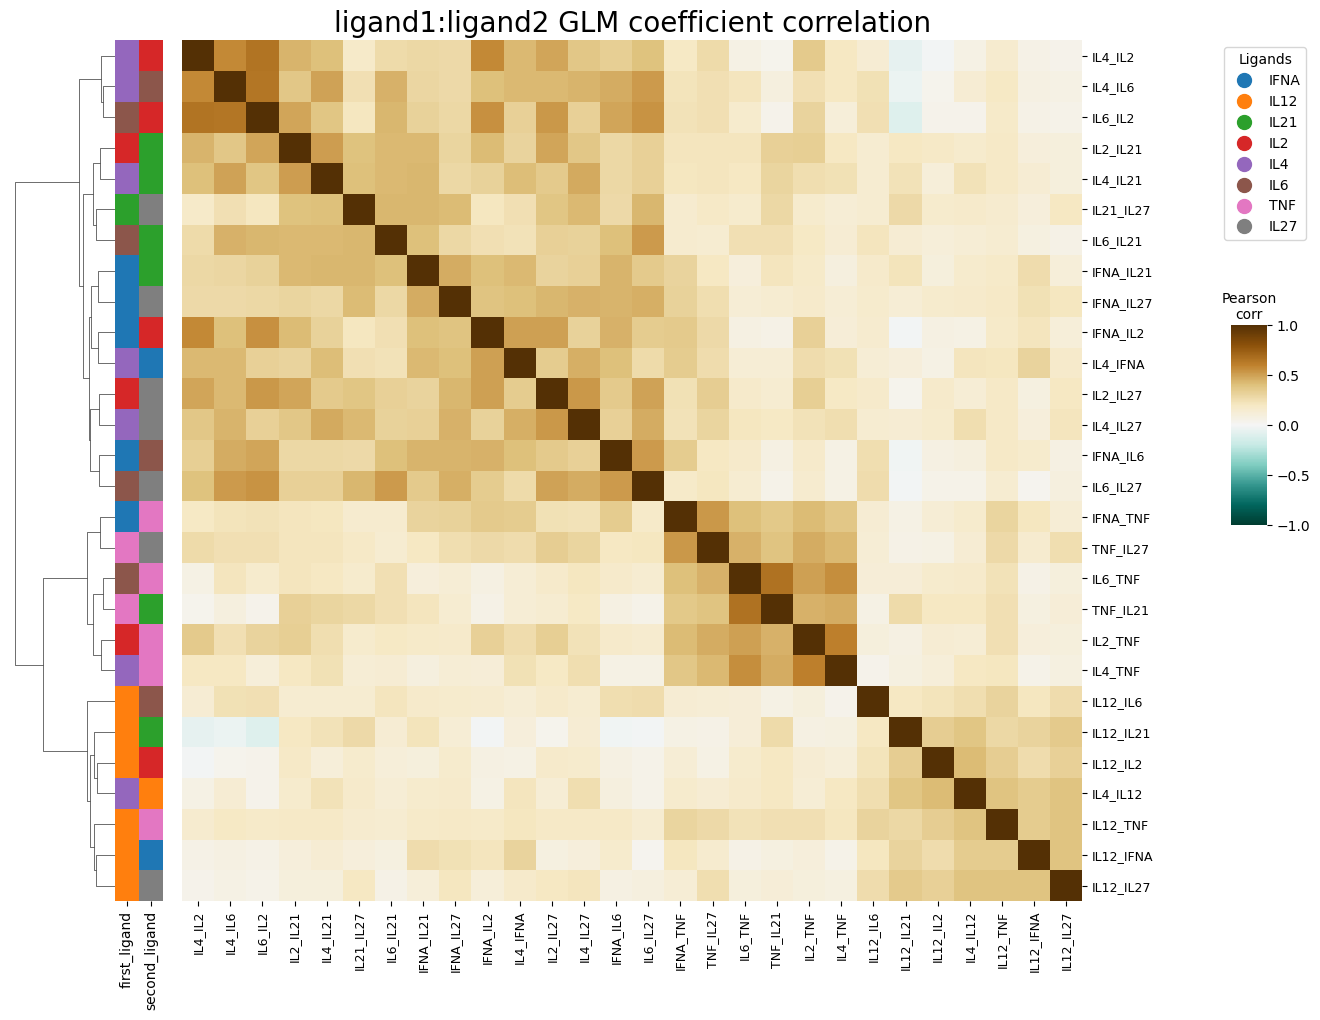

In [62]:
plot_heatmap_anno(
    corr_matrix=interCoeffCorr,
    anno=anno,
    legend_handles=legend_handles,
    unique_ligands=unique_ligands,
    title='ligand1:ligand2 GLM coefficient correlation',
    cmap='BrBG_r',
    method='ward',
    vmax=1,
    vmin=-1
)

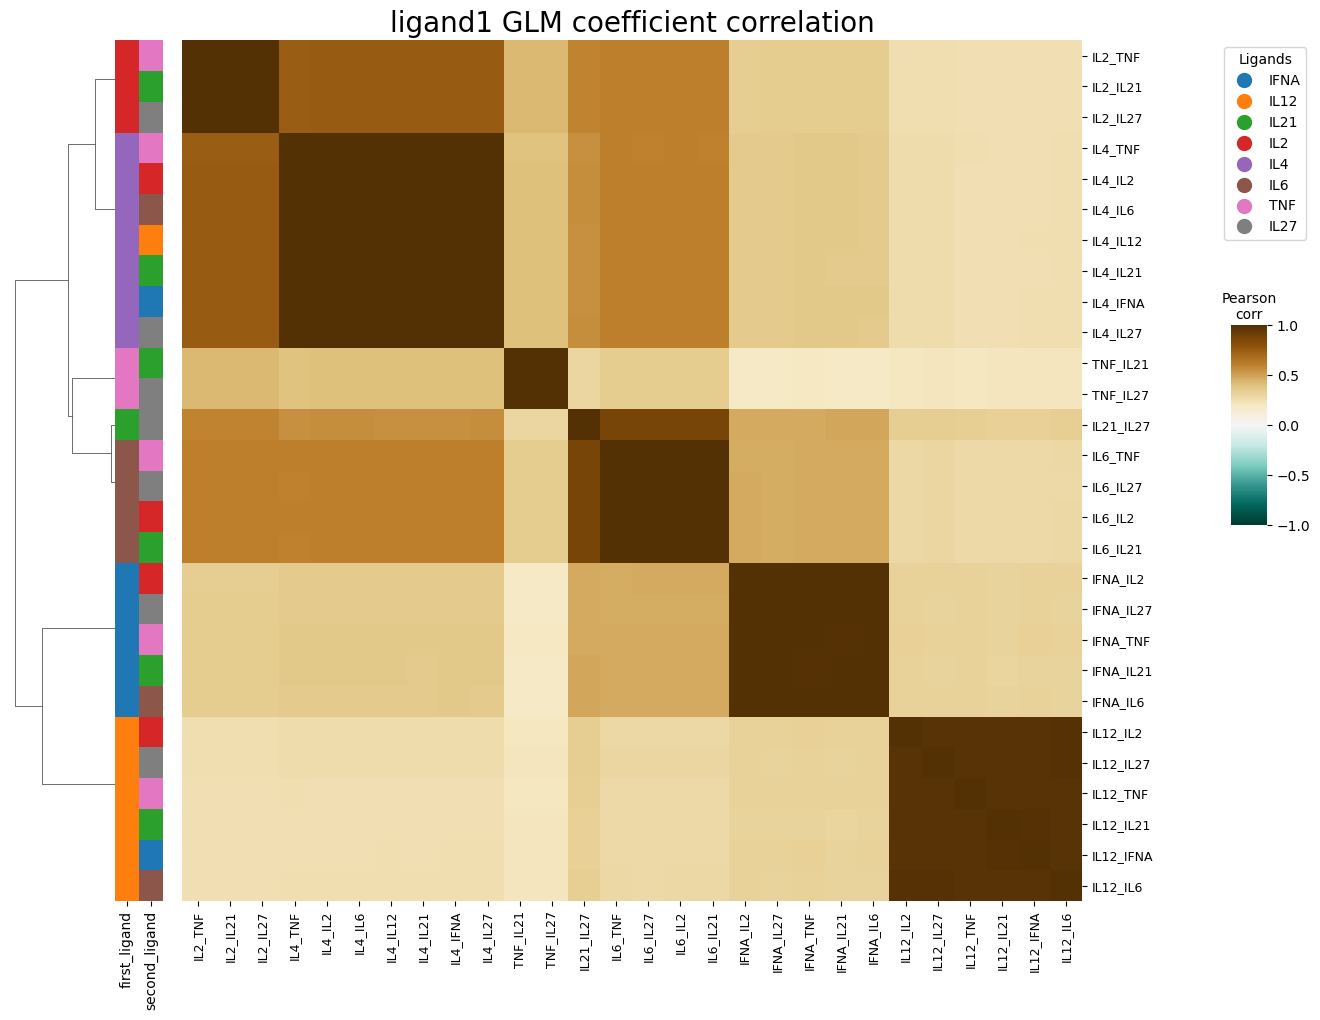

In [63]:
plot_heatmap_anno(
    corr_matrix=ligand1Corr,
    anno=anno,
    legend_handles=legend_handles,
    unique_ligands=unique_ligands,
    title='ligand1 GLM coefficient correlation',
    cmap='BrBG_r',
    method='ward',
    vmax=1,
    vmin=-1
)

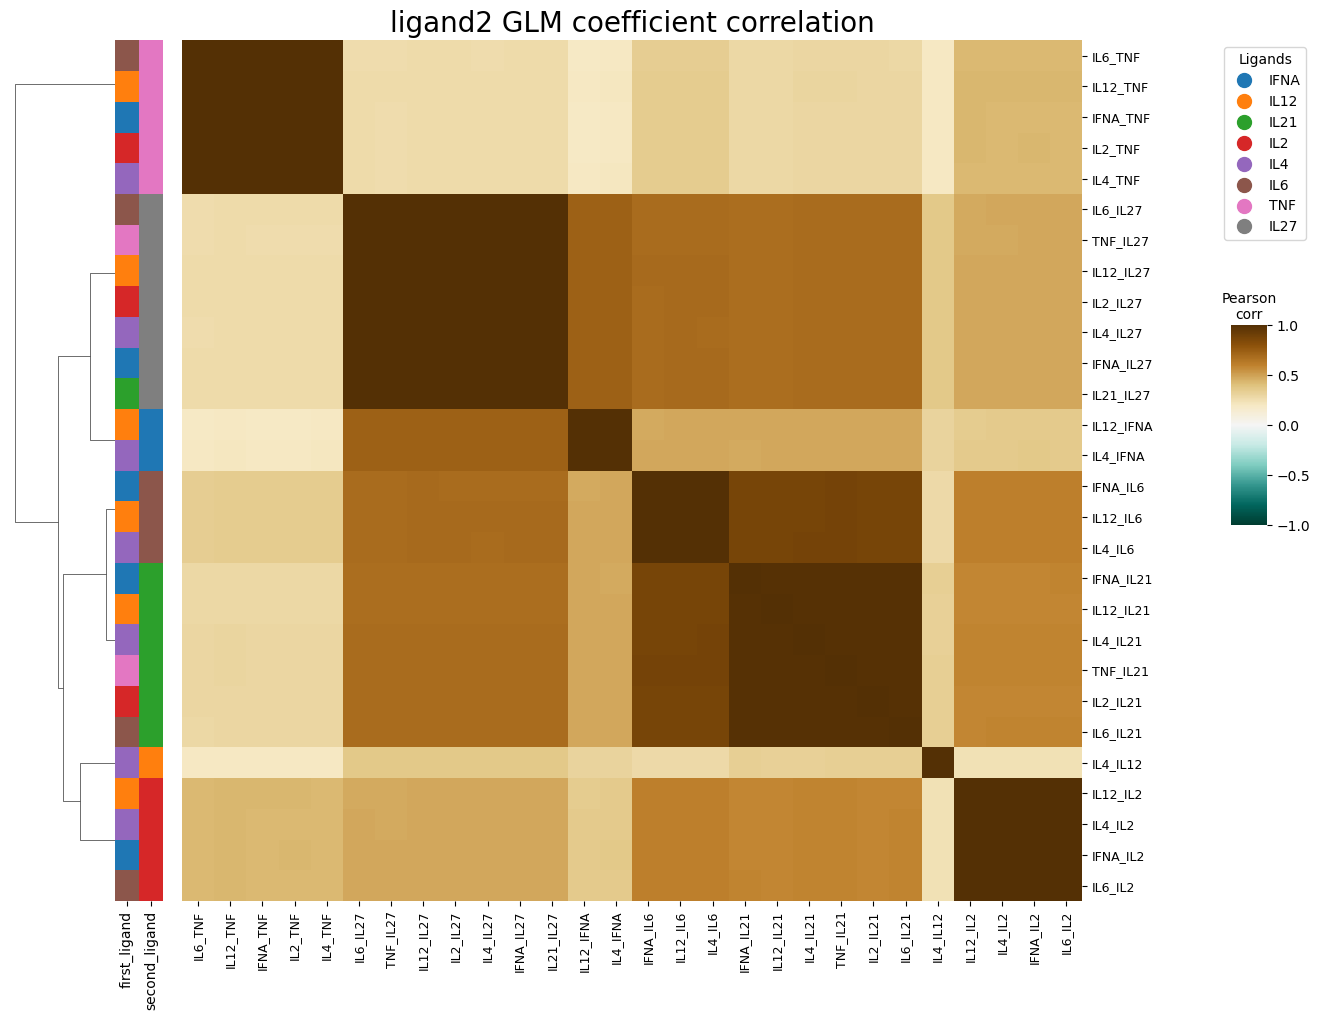

In [64]:
plot_heatmap_anno(
    corr_matrix=ligand2Corr,
    anno=anno,
    legend_handles=legend_handles,
    unique_ligands=unique_ligands,
    title='ligand2 GLM coefficient correlation',
    cmap='BrBG_r',
    method='ward',
    vmax=1,
    vmin=-1
)

# MDE Embedding

Here, I will use pymde to perform minimal distortion embedding. This is inspired by the usage of MDE in visualizing perturbations in the Weissman genome-wide dataset (https://pubmed.ncbi.nlm.nih.gov/35688146/). I will essentially be copying their approach, although because this data is much lower dimension, I will try using spectral embedding and just using the zscore counts directly.

The key thing to note in their approach is that by z-scoring each cell prior to using MDE. This allows for **MDE to minimize correlation distance rather than euclidean distance, making the comparisons scale invariant**.

In [14]:
import pymde
from scipy.stats import zscore
from sklearn.manifold import SpectralEmbedding

## Create data copy and preprocess

In [15]:
# make copy of data 
adata = dataNorm.copy()
adata.X = adata.layers['log1p_norm'].copy()
# filter to remove low genes
sc.pp.filter_genes(adata, min_cells=len(adata)*0.01) # filter for genes in >1% of cells
# find HVGs
sc.pp.highly_variable_genes(adata, n_top_genes=2100-82)
# Remove TCR and IG genes
adata, matching_genes = update_highly_variable_genes(adata, r"^Tra[vj]|^Trb[vdj]|^Igk[vc]|^Igl[vc]|^Ighv")
print(f"Number of highly variable genes remaining: {adata.var['highly_variable'].sum()}")

Number of highly variable genes remaining: 1999


In [16]:
# subset adata only on HVGs
adata_hv = adata[:, adata.var['highly_variable']]
# return adata with mean aggregated values
adata_mean = mean_aggr_adata(adata_hv, aggregate_columns=['ligand_call_oBC_CR','group_call_CR'])
# perform z-scoring by row (by cell)
zscore_counts = zscore(adata_mean.X, axis = 1)

/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [17]:
# Extract the unique ligands from the 'ligand_call_oBC_CR' column
unique_ligands = set(
    ligand
    for ligands in adata_mean.obs["ligand_call_oBC_CR"].str.split("_")
    for ligand in ligands
)

# Create a new column for each unique ligand with "single", "double", or "none" labels
for ligand in unique_ligands:
    # Classify each row
    adata_mean.obs[f"has_{ligand}"] = adata_mean.obs["ligand_call_oBC_CR"].apply(
        lambda x: (
            "single" if ligand in x.split("_") and any(linker in x.split("_") for linker in ["linker-1", "linker-2"])
            else "double" if ligand in x.split("_") and len(x.split("_")) > 1 and not any(linker in x.split("_") for linker in ["linker-1", "linker-2"])
            else "none"
        )
    )
    
    # Convert to categorical and reorder the categories
    adata_mean.obs[f"has_{ligand}"] = adata_mean.obs[f"has_{ligand}"].astype(
        pd.CategoricalDtype(categories=['none','single','double'], ordered=True)
    )

adata_mean.obs

,ligand_call_oBC_CR,group_call_CR,has_IL21,has_TNF,has_linker-1,has_linker-2,has_IL12,has_IL27,has_IL4,has_IL2,has_IL6,has_IFNA
0,IFNA_IL21,group2,double,none,none,none,none,none,none,none,none,double
1,IFNA_IL21,group3,double,none,none,none,none,none,none,none,none,double
2,IFNA_IL27,group1,none,none,none,none,none,double,none,none,none,double
3,IFNA_IL27,group2,none,none,none,none,none,double,none,none,none,double
4,IFNA_IL27,group3,none,none,none,none,none,double,none,none,none,double
...,...,...,...,...,...,...,...,...,...,...,...,...
112,TNF_linker-2,group2,none,single,none,single,none,none,none,none,none,none
113,TNF_linker-2,group3,none,single,none,single,none,none,none,none,none,none
114,linker-1_linker-2,group1,none,none,single,single,none,none,none,none,none,none
115,linker-1_linker-2,group2,none,none,single,single,none,none,none,none,none,none


Here, I'm just making a unique binary column for each ligand to say whether it has it or not. 

## MDE with zscore counts
Note that z-score in this context refers to cell-level z-scoring not normalizing to control z-scoring.

In [18]:
# Use pymde for high-dimensional embedding
mde = pymde.preserve_neighbors(
    zscore_counts,
    embedding_dim=2,
    repulsive_fraction=10
)
embedding = mde.embed()

# Add the embedding to the AnnData object
adata_mean.obsm["mde"] = embedding.numpy()

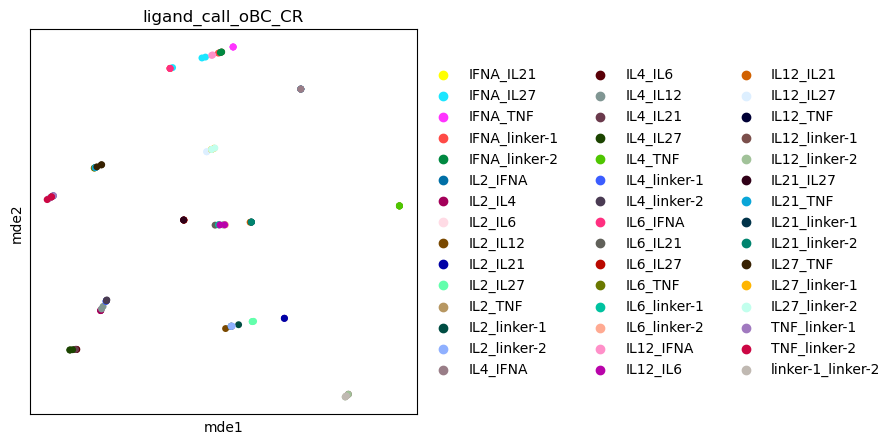

In [19]:
plt.rcParams["figure.figsize"] = (5, 5)  # Width, height in inches

# Optional: Visualize the embedding
sc.pl.embedding(adata_mean, basis="mde",
                color=["ligand_call_oBC_CR"],
                ncols=1,
                size=100)  # Replace "sample_column" with metadata column

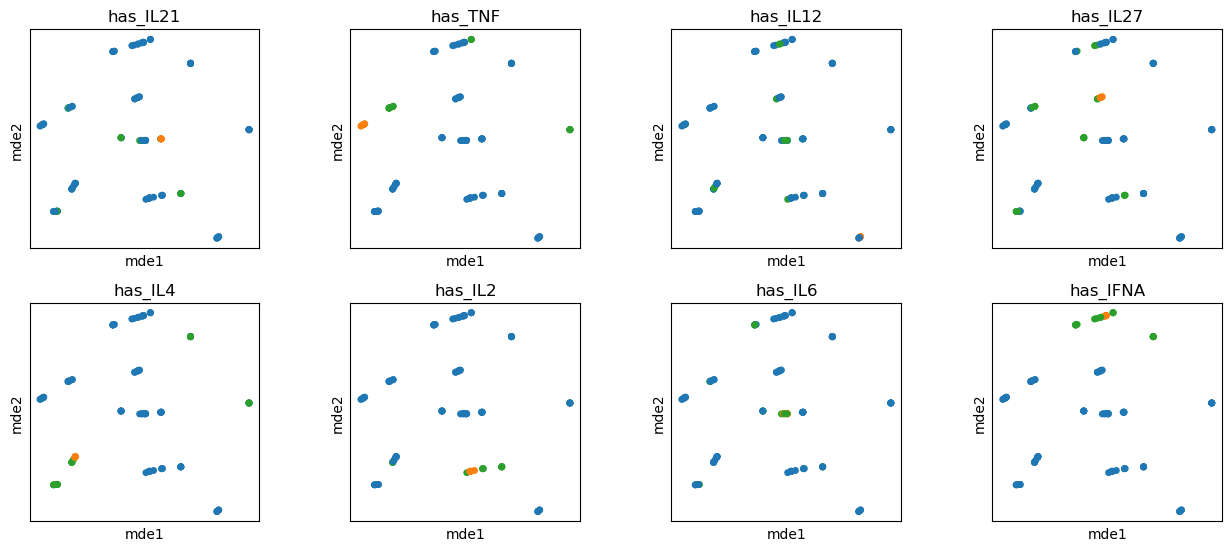

In [20]:
plt.rcParams["figure.figsize"] = (3, 3)  # Width, height in inches

# Filter columns that start with "has_I" or "has_T"
filtered_columns = adata_mean.obs.columns[
    adata_mean.obs.columns.str.startswith("has_I") | adata_mean.obs.columns.str.startswith("has_T")
]

# Optional: Visualize the embedding
sc.pl.embedding(adata_mean, basis="mde",
                color=filtered_columns,
                ncols=4,
                size=100,
                legend_loc="none"
                )

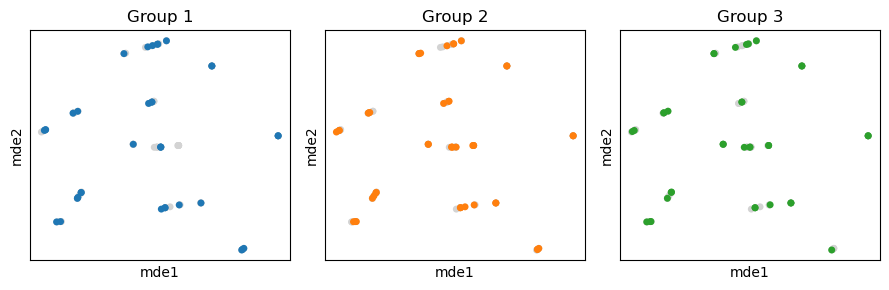

In [21]:
# Create a figure with 1 row and 3 columns for side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(9, 3))  # Adjust figsize as needed (width, height)

# Plot group1
sc.pl.embedding(
    adata_mean, basis="mde", color="group_call_CR",
    groups=["group1"], size=100, ax=axes[0],
    show=False,legend_loc="none"
)
axes[0].set_title("Group 1")

# Plot group2
sc.pl.embedding(
    adata_mean, basis="mde", color="group_call_CR",
    groups=["group2"], size=100, ax=axes[1],
    show=False,legend_loc="none"
)
axes[1].set_title("Group 2")

# Plot group3
sc.pl.embedding(
    adata_mean, basis="mde", color="group_call_CR",
    groups=["group3"], size=100, ax=axes[2],
    show=False, legend_loc="none"
)
axes[2].set_title("Group 3")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


## MDE with spectral embedding

In [22]:
# Spectral embedding initialization using sklearn
spectral_embedder = SpectralEmbedding(
    n_components=20,
    affinity='nearest_neighbors',
    n_jobs=-1,
)
spectral_embedding = spectral_embedder.fit_transform(zscore_counts)

# Use pymde for high-dimensional embedding
mde = pymde.preserve_neighbors(
    spectral_embedding,
    embedding_dim=2,  # Dimensionality of the pymde embedding
    repulsive_fraction=10,  # Adjust repulsion strength
    verbose=True  # Print progress
)
embedding = mde.embed()

# Add the embedding to the AnnData object
adata_mean.obsm["mde"] = embedding.numpy()

Nov 26 10:24:33 AM: Computing 5-nearest neighbors, with max_distance=None
Nov 26 10:24:33 AM: Exact nearest neighbors by brute force 
Nov 26 10:24:33 AM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Nov 26 10:24:33 AM: The following items have duplicates [  5   6  24  37  38  49  74  87  88  89  90 103 111 114 116]
Nov 26 10:24:33 AM: Computing quadratic initialization.


/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


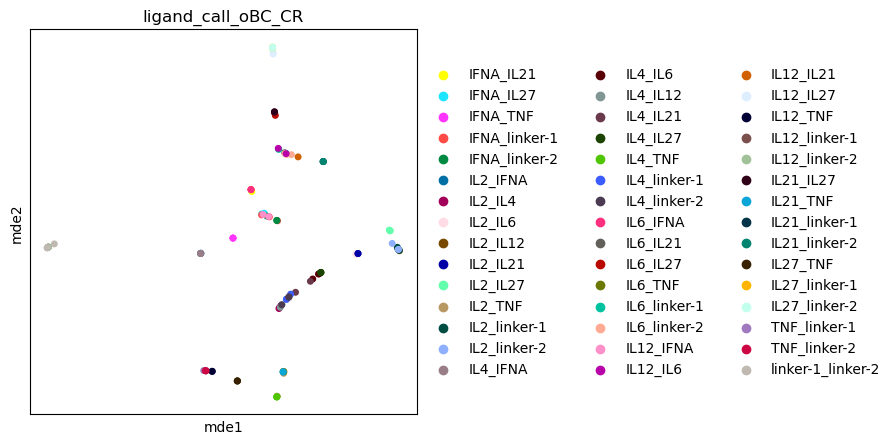

In [23]:
plt.rcParams["figure.figsize"] = (5, 5)  # Width, height in inches

# Optional: Visualize the embedding
sc.pl.embedding(adata_mean, basis="mde",
                color=["ligand_call_oBC_CR"],
                ncols=1,
                size=100)  # Replace "sample_column" with metadata column

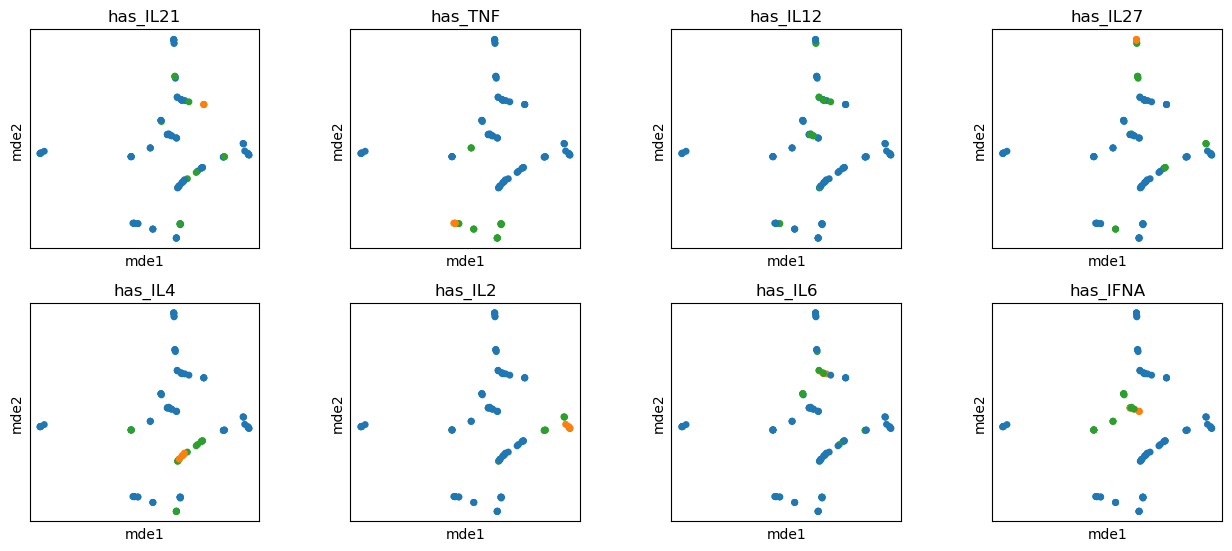

In [24]:
plt.rcParams["figure.figsize"] = (3, 3)  # Width, height in inches

# Filter columns that start with "has_I" or "has_T"
filtered_columns = adata_mean.obs.columns[
    adata_mean.obs.columns.str.startswith("has_I") | adata_mean.obs.columns.str.startswith("has_T")
]

# Optional: Visualize the embedding
sc.pl.embedding(adata_mean, basis="mde",
                color=filtered_columns,
                ncols=4,
                size=100,
                legend_loc="none"
                )

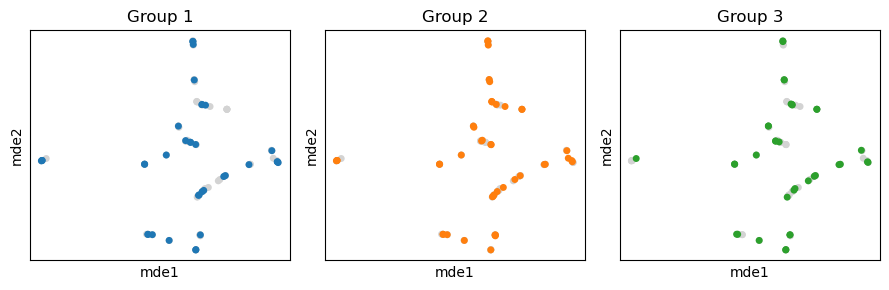

In [25]:
# Create a figure with 1 row and 3 columns for side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(9, 3))  # Adjust figsize as needed (width, height)

# Plot group1
sc.pl.embedding(
    adata_mean, basis="mde", color="group_call_CR",
    groups=["group1"], size=100, ax=axes[0],
    show=False,legend_loc="none"
)
axes[0].set_title("Group 1")

# Plot group2
sc.pl.embedding(
    adata_mean, basis="mde", color="group_call_CR",
    groups=["group2"], size=100, ax=axes[1],
    show=False,legend_loc="none"
)
axes[1].set_title("Group 2")

# Plot group3
sc.pl.embedding(
    adata_mean, basis="mde", color="group_call_CR",
    groups=["group3"], size=100, ax=axes[2],
    show=False, legend_loc="none"
)
axes[2].set_title("Group 3")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
